# Analiza czynników mogących wpływać na prawdopodobieństwo powrotu użytkownika na stronę

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

Załadowanie zbioru danych i oczyszczenie z niepotrzebnych znaków

In [2]:
file = "dane.csv"
df = pd.read_csv(file, header=0, sep="[;]", engine="python", 
                 names=("client_id","action_time", "pagePath", "medium", "eventAction", "date"))
df.client_id = df.client_id.str[1:]
df.date = df.date.str[:-1]
df.head()

,client_id,action_time,pagePath,medium,eventAction,date
0,d0a213b0718cd0e10475ce11d893c3cc,2020-07-29T15:38:27Z,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,pageview,29.07.2020
1,4416f6ec763cc9e65ca17482d3960971,2020-07-29T21:03:06Z,/,(none),pageview,29.07.2020
2,c3d6e02ad3e2a781dba7c48a4d354199,2020-07-29T07:51:28Z,/o-portalu,banner,pageview,29.07.2020
3,3bd4feb129163c7889a70d3d12c6e82d,2020-07-29T12:23:00Z,"/lekcja/geografia,12901cca29551ad7d556962231a1...",organic,pageview,29.07.2020
4,3d90c06c313a2120ce98ff14b6581570,2020-07-29T12:27:30Z,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",organic,pageview,29.07.2020


Opis zmiennych:<br />&nbsp;&nbsp;&nbsp;
    client_id - ID użytkownika (pozyskiwane za pomocą cookie)<br />&nbsp;&nbsp;&nbsp;
    ts - dokładny czas, w którym nastąpiło wydarzenie<br />&nbsp;&nbsp;&nbsp;
    pagePath - ścieżka strony, która była oglądana<br />&nbsp;&nbsp;&nbsp;
    medium - czyli medium, z którego użytkownik przyszedł na stronę <br />&nbsp;&nbsp;&nbsp;
    eventAction - rodzaj akcji wykonanej przez użytkownika<br />&nbsp;&nbsp;&nbsp;
    date - data zdarzenia<br />&nbsp;&nbsp;&nbsp;
    <br />
Opis mediów kolumny "medium":<br />&nbsp;&nbsp;&nbsp;
    cpc - wejście z kampanii marketingowej<br />&nbsp;&nbsp;&nbsp;
    organic - wejście z wyszukiwarki<br />&nbsp;&nbsp;&nbsp;
    banner - wejście z baneru reklamowego<br />&nbsp;&nbsp;&nbsp;
    referral - wejście z linku polecającego<br />&nbsp;&nbsp;&nbsp;
    email - wejście przez mail<br />&nbsp;&nbsp;&nbsp;
    post - wejście przez post<br />&nbsp;&nbsp;&nbsp;
    link - wejście przez link<br />&nbsp;&nbsp;&nbsp;
    webpush - wejście przez wiadomości, wysyłane przez stronę internetową<br />&nbsp;&nbsp;&nbsp;

Konwersja kolumny "date" na *datetime* i utworzenie kolumny "time" z czasem zdarzenia

In [3]:
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df["action_time"] = pd.to_datetime(df["action_time"]).dt.time

In [4]:
print(df.isnull().values.sum())

0


 Dane nie zawierają wartości pustych, nie wymagają więc oczyszczenia z nich.


In [5]:
df["medium"] = df["medium"].astype("category")

Zmiana typu danych kolumny "medium" na typ danych *category*

In [6]:
df.describe()

,client_id,action_time,pagePath,medium,eventAction,date
count,466822,466822,466822,466822,466822,466822
unique,230193,70553,2549,10,1,37
top,64e4c7ca28927cfd62a503e100afe752,10:08:41,/,organic,pageview,2020-08-21 00:00:00
freq,855,26,67224,260306,466822,25938
first,NaN,NaN,NaN,NaN,NaN,2020-07-29 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2020-10-09 00:00:00


In [7]:
df.drop(["eventAction"], axis="columns", inplace=True)

Kolumna "eventAction" zostaje usunięta z powodu występowania tylko jednej zmiennej.

Podliczenie wystąpień każdego z mediów, z którego użytkownik mógł wejść na stronę.

In [8]:
df["medium"].value_counts()

organic      260306
(none)        67090
cpc           50864
banner        46942
referral      30169
email         11243
post            102
link             74
webpush          31
(not set)         1
Name: medium, dtype: int64

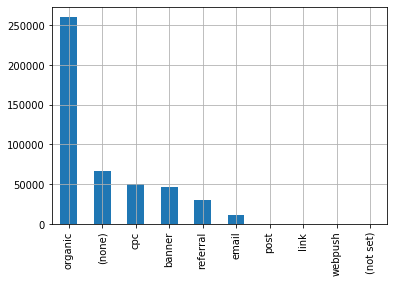

In [9]:
df["medium"].value_counts().plot(kind="bar", grid=True)

W zbiorze istnieją dwie pozycje nieprzypisane do żadnego z mediów: (none) i (not set).

In [10]:
df.loc[df["medium"] == "(none)", "medium"] = "(not set)"

In [11]:
df["pagePath"].head(20)

0     /lekcja/biologia,75f95eb9a371db8c2ea854da85219502
1                                                     /
2                                            /o-portalu
3     /lekcja/geografia,12901cca29551ad7d556962231a1...
4     /lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...
5     /lekcja/jezyk-polski,8a99b0c8047266b628e7a7d3b...
6                                                     /
7                                                     /
8                                                     /
9                                            /o-portalu
10                                                    /
11                                                    /
12    /lekcja/jezyk-polski,9c53c1abcacdf5cf9553c8388...
13                                                    /
14                                    /?standalone=true
15    /lekcja/historia,6d6334ff96cc0d0d429537dbc3c69366
16    /lekcja/historia,6d6334ff96cc0d0d429537dbc3c69366
17                                              

Stworzenie kolumny "pageMainCat" z kategoriami występującymi w kolumnie "pagePath". Ścieżki nie przypisane do żadnej z kategorii, otrzymują etykietę "Others"

In [12]:
df["pageMainCat"] = df["pagePath"]

In [13]:
main_categories = {
    "/lekcja/": "lekcja", 
    "/kategorie/": "kategorie",
    "/fiszki-i-quizy/": "fiszki-i-quizy",
    "/sprawdz-sie/": "sprawdz-sie",    
    "/quiz/": "quiz",
    "/fiszki/": "fiszki",
    "/szukaj/": "szukaj",
    "lesson/preview": "lesson/preview",
    "/o-portalu": "o-portalu",
}
    
for key, value in main_categories.items():
    df["pageMainCat"] = df["pageMainCat"].astype(str).apply(lambda x:  value if key in x else x) 
    
cat_set = set(main_categories.values())
df["pageMainCat"] = df["pageMainCat"].apply(lambda x: x if x in cat_set else "Others")  

In [14]:
df["pageMainCat"] = df["pageMainCat"].astype("category")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466822 entries, 0 to 466821
Data columns (total 6 columns):
client_id      466822 non-null object
action_time    466822 non-null object
pagePath       466822 non-null object
medium         466822 non-null category
date           466822 non-null datetime64[ns]
pageMainCat    466822 non-null category
dtypes: category(2), datetime64[ns](1), object(3)
memory usage: 15.1+ MB


In [16]:
df

,client_id,action_time,pagePath,medium,date,pageMainCat
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",organic,2020-07-29,lekcja
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,(not set),2020-07-29,Others
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,banner,2020-07-29,o-portalu
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",organic,2020-07-29,lekcja
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",organic,2020-07-29,lekcja
...,...,...,...,...,...,...
466817,4aeb67e947bf0f68727da4531cb2e730,20:23:49,/,cpc,2020-09-03,Others
466818,85298782f748e544275ea0ba55767d39,12:44:06,"/lekcja/biologia,43eb0ab6190bc7e8acf5d294119e22c9",organic,2020-09-12,lekcja
466819,fcb3a6846e37f653bd39b2f1cc9cd338,13:58:39,"/lekcja/historia,a7020fcc21842131d9a211d1e9c558fa",organic,2020-09-18,lekcja
466820,fcb3a6846e37f653bd39b2f1cc9cd338,14:24:09,"/lekcja/historia,a7020fcc21842131d9a211d1e9c558fa",cpc,2020-09-18,lekcja


Ilustracja częstości występowania danej głównej kategorii z kolumny "pageMainCat".

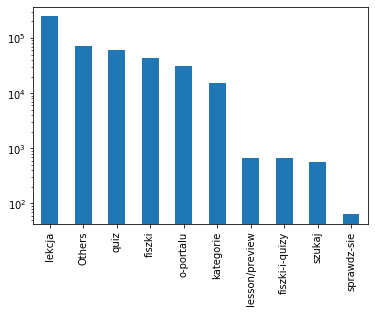

In [17]:
df["pageMainCat"].value_counts().plot(kind="bar", logy=True)

Kodowanie kolumny "medium", gdzie "organic" przyjmuje wartość jeden, a pozostałe rodzje przyjmują wartość zero.

In [18]:
df_specific = df.copy()
df_specific["Organic_code"] = np.where(df_specific["medium"].str.contains("organic"), 1, 0)
df_specific = df_specific.drop("medium", axis = 1)

df_specific.head()

,client_id,action_time,pagePath,date,pageMainCat,Organic_code
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,lekcja,1
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,2020-07-29,Others,0
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,2020-07-29,o-portalu,0
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",2020-07-29,lekcja,1
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",2020-07-29,lekcja,1


Kodowanie zmiennych "pageMainCat" za pomocą metody *Target/Guided Encoding*.

Obliczenie prawdopodobieństwa każdej z głównych kategorii na podstawie wartości celu kolumny "Organic_code".

In [19]:
df_specific.groupby(["pageMainCat"])["Organic_code"].mean()

pageMainCat
Others            0.140407
fiszki            0.285261
fiszki-i-quizy    0.758673
kategorie         0.371252
lekcja            0.858868
lesson/preview    0.239291
o-portalu         0.002661
quiz              0.351063
sprawdz-sie       0.640625
szukaj            0.307554
Name: Organic_code, dtype: float64

Największe prawdopodobieństwo, że użytkownik wchodzący na stronę przez wyszukiwarkę (organic) występuje dla lekcji - ok. 86%.

In [20]:
Encoded_Lables = df_specific.groupby(["pageMainCat"])["Organic_code"].mean().sort_values().index

Stworzenie słowników zawierających klucz jako nazwę głównej kategorii i wartościami jako wspólny ranking prawdopodobieństwa.

In [21]:
Encoded_Lables_Ranks = { k:i for i, k in enumerate(Encoded_Lables, 0) }

Stworzenie nowej kolumny "pageMainCat_Encoded" i zmapowanie wartośći głównych kategorii z rankingiem wspólnego prawdopodobieństwa.

In [22]:
df_specific["pageMainCat_Encoded"] = df_specific["pageMainCat"].map(Encoded_Lables_Ranks)

In [23]:
df_specific

,client_id,action_time,pagePath,date,pageMainCat,Organic_code,pageMainCat_Encoded
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,lekcja,1,9
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,2020-07-29,Others,0,1
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,2020-07-29,o-portalu,0,0
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",2020-07-29,lekcja,1,9
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",2020-07-29,lekcja,1,9
...,...,...,...,...,...,...,...
466817,4aeb67e947bf0f68727da4531cb2e730,20:23:49,/,2020-09-03,Others,0,1
466818,85298782f748e544275ea0ba55767d39,12:44:06,"/lekcja/biologia,43eb0ab6190bc7e8acf5d294119e22c9",2020-09-12,lekcja,1,9
466819,fcb3a6846e37f653bd39b2f1cc9cd338,13:58:39,"/lekcja/historia,a7020fcc21842131d9a211d1e9c558fa",2020-09-18,lekcja,1,9
466820,fcb3a6846e37f653bd39b2f1cc9cd338,14:24:09,"/lekcja/historia,a7020fcc21842131d9a211d1e9c558fa",2020-09-18,lekcja,0,9


In [24]:
df_onehot = df_specific.copy()
df_onehot = pd.get_dummies(df_onehot, columns=["pageMainCat"], prefix = ["pageMainCat"])

df_onehot.head()

,client_id,action_time,pagePath,date,Organic_code,pageMainCat_Encoded,pageMainCat_Others,pageMainCat_fiszki,pageMainCat_fiszki-i-quizy,pageMainCat_kategorie,pageMainCat_lekcja,pageMainCat_lesson/preview,pageMainCat_o-portalu,pageMainCat_quiz,pageMainCat_sprawdz-sie,pageMainCat_szukaj
0,d0a213b0718cd0e10475ce11d893c3cc,15:38:27,"/lekcja/biologia,75f95eb9a371db8c2ea854da85219502",2020-07-29,1,9,0,0,0,0,1,0,0,0,0,0
1,4416f6ec763cc9e65ca17482d3960971,21:03:06,/,2020-07-29,0,1,1,0,0,0,0,0,0,0,0,0
2,c3d6e02ad3e2a781dba7c48a4d354199,07:51:28,/o-portalu,2020-07-29,0,0,0,0,0,0,0,0,1,0,0,0
3,3bd4feb129163c7889a70d3d12c6e82d,12:23:00,"/lekcja/geografia,12901cca29551ad7d556962231a1...",2020-07-29,1,9,0,0,0,0,1,0,0,0,0,0
4,3d90c06c313a2120ce98ff14b6581570,12:27:30,"/lekcja/jezyk-polski,c106aef9f68b2b03b8afe7d89...",2020-07-29,1,9,0,0,0,0,1,0,0,0,0,0


Kodowanie zmiennych "pageMainCat" za pomocą metody *One Hot Encoding*.

Obliczenie Współczynnika V Craméra pomiędzy kolumnami "Organic_code" i "pageMainCat_Encoded".

In [25]:
def cramers_v(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(df_specific["Organic_code"], df_specific["pageMainCat_Encoded"]).as_matrix()
cramers_v(confusion_matrix)

C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


0.6621484147835431

Zachodzi silna korelacja pomiędzy wejściem na stronę przez wyszukiwarkę (organic), a głównymi kategoriami, na które wchodzą używtkownicy.

In [26]:
cm_Others = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_Others"]).as_matrix()
cm_fiszki = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_fiszki"]).as_matrix()
cm_fiszki_i_quizy = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_fiszki-i-quizy"]).as_matrix()
cm_kategorie = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_kategorie"]).as_matrix()
cm_lekcja = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_lekcja"]).as_matrix()
cm_lesson_preview = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_lesson/preview"]).as_matrix()
cm_o_portalu = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_o-portalu"]).as_matrix()
cm_quiz = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_quiz"]).as_matrix()
cm_sprawdz_sie = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_sprawdz-sie"]).as_matrix()
cm_szukaj = pd.crosstab(df_onehot["Organic_code"], df_onehot["pageMainCat_szukaj"]).as_matrix()

C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\owkr9001\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_l

In [27]:
data = {"Kategoria":  ["lekcja", "Others","fiszki","quiz","kategorie", "lesson_preview", "fiszki_i_quizy", "szukaj", "sprawdz_sie"],
        "Współczynnik V Craméra": [cramers_v(cm_lekcja), cramers_v(cm_Others) ,cramers_v(cm_fiszki), cramers_v(cm_quiz),
                                   cramers_v(cm_kategorie), cramers_v(cm_lesson_preview), cramers_v(cm_fiszki_i_quizy),
                                  cramers_v(cm_szukaj), cramers_v(cm_sprawdz_sie)]
        }

Cramér = pd.DataFrame (data, columns = ["Kategoria","Współczynnik V Craméra"])

Cramér

,Kategoria,Współczynnik V Craméra
0,lekcja,0.637651
1,Others,0.355948
2,fiszki,0.174430
3,quiz,0.159084
4,kategorie,0.069299
5,lesson_preview,0.024324
6,fiszki_i_quizy,0.015139
7,szukaj,0.017261
8,sprawdz_sie,0.001001


Po sprawdzeniu Współczynnika korelacji V Cramera, można określić, że z pośród rozpatrywanych kategorii, jedynie "lekcja" wykazuje realną korelację z wejściem na stronę przez wyszukiwarkę (organic). 

In [28]:
df["client_id"].value_counts()

64e4c7ca28927cfd62a503e100afe752    855
7fd23ab30cb37c91cf57a30731c284be    827
12362cc4d327fb9dbd0cc4dbb9a55763    775
7d4374561c5e2cf5302d7b82c41dc6c7    766
3fe25b59f12d75f633cf1ac19b316298    754
                                   ... 
f2ed1359b5f01e14548f76ec79a5e814      1
836d21e37c3c2f726194baf54b5b7610      1
580a13327ec0b0b013f4fbe77a979a22      1
ef057106e5dc9953ca702fcbd32fb25c      1
79203766ad78087e175cde28b2e07464      1
Name: client_id, Length: 230193, dtype: int64

In [30]:
df["client_id"].value_counts().sum()

466822

In [31]:
df_onehot['week'] = df_onehot['date'].dt.week

In [32]:
df_onehot['week'].value_counts()

34    134390
33    128802
32    117908
31     85696
35        19
36         3
38         2
41         1
37         1
Name: week, dtype: int64

In [33]:
df_onehot["client_id_count"] = df.groupby("client_id")["client_id"].transform("count")
df_onehot = df_onehot.sort_values("client_id_count", ascending=False)

In [34]:
df_onehot["client_id_code"] = np.where(df_onehot["client_id_count"] == 1, 1, 0)
df_onehot

,client_id,action_time,pagePath,date,Organic_code,pageMainCat_Encoded,pageMainCat_Others,pageMainCat_fiszki,pageMainCat_fiszki-i-quizy,pageMainCat_kategorie,pageMainCat_lekcja,pageMainCat_lesson/preview,pageMainCat_o-portalu,pageMainCat_quiz,pageMainCat_sprawdz-sie,pageMainCat_szukaj,week,client_id_count,client_id_code
354859,64e4c7ca28927cfd62a503e100afe752,10:39:30,/quiz/54497bf1-8dc1-44c2-ac4c-5971db09520d,2020-08-17,0,5,0,0,0,0,0,0,0,1,0,0,34,855,0
257997,64e4c7ca28927cfd62a503e100afe752,17:56:16,/quiz/2cb641e5-c87b-44e9-8c1b-6ba18824923b,2020-08-13,0,5,0,0,0,0,0,0,0,1,0,0,33,855,0
448085,64e4c7ca28927cfd62a503e100afe752,03:09:59,/quiz/3842787b-6012-464d-b4d0-3a7a8aabc0f1,2020-08-22,0,5,0,0,0,0,0,0,0,1,0,0,34,855,0
448086,64e4c7ca28927cfd62a503e100afe752,03:10:04,/quiz/3842787b-6012-464d-b4d0-3a7a8aabc0f1,2020-08-22,0,5,0,0,0,0,0,0,0,1,0,0,34,855,0
448087,64e4c7ca28927cfd62a503e100afe752,03:10:08,/quiz/3842787b-6012-464d-b4d0-3a7a8aabc0f1,2020-08-22,0,5,0,0,0,0,0,0,0,1,0,0,34,855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332252,e8b2621af11e82af0cf893d469e1f4d6,09:01:57,"/lekcja/historia,fbc16bbb9cf844cb0477c5b2b490df70",2020-08-16,1,9,0,0,0,0,1,0,0,0,0,0,33,1,1
332253,edfe1f046b2a02bab6946bca214b9751,10:48:49,"/lekcja/jezyk-polski,16cc278854bf2bd81ef436ee6...",2020-08-16,1,9,0,0,0,0,1,0,0,0,0,0,33,1,1
332254,7275b342c1d8ed878136191ac193b77d,14:55:57,"/lekcja/jezyk-polski,2b627e0ddb69e28f6aa8b8d26...",2020-08-16,1,9,0,0,0,0,1,0,0,0,0,0,33,1,1
166036,29aed918a4c31a17a328be754e0784f5,18:50:39,"/lekcja/jezyk-angielski,14652226b942619d90bcb8...",2020-08-08,1,9,0,0,0,0,1,0,0,0,0,0,32,1,1


In [35]:
df_onehot = df_onehot.drop("client_id", axis = 1)

In [36]:
df_onehot = df_onehot.drop("client_id_count", axis = 1)

In [37]:
df_onehot = df_onehot.drop("pagePath", axis = 1)

In [38]:
df_onehot = df_onehot.drop("action_time", axis = 1)

In [39]:
df_onehot = df_onehot.drop("date", axis = 1)

In [40]:
df_onehot

,Organic_code,pageMainCat_Encoded,pageMainCat_Others,pageMainCat_fiszki,pageMainCat_fiszki-i-quizy,pageMainCat_kategorie,pageMainCat_lekcja,pageMainCat_lesson/preview,pageMainCat_o-portalu,pageMainCat_quiz,pageMainCat_sprawdz-sie,pageMainCat_szukaj,week,client_id_code
354859,0,5,0,0,0,0,0,0,0,1,0,0,34,0
257997,0,5,0,0,0,0,0,0,0,1,0,0,33,0
448085,0,5,0,0,0,0,0,0,0,1,0,0,34,0
448086,0,5,0,0,0,0,0,0,0,1,0,0,34,0
448087,0,5,0,0,0,0,0,0,0,1,0,0,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332252,1,9,0,0,0,0,1,0,0,0,0,0,33,1
332253,1,9,0,0,0,0,1,0,0,0,0,0,33,1
332254,1,9,0,0,0,0,1,0,0,0,0,0,33,1
166036,1,9,0,0,0,0,1,0,0,0,0,0,32,1


In [41]:
X = np.asarray(df_onehot.iloc[:, :-1].values )
Y = np.asarray(df_onehot.iloc[:, -1].values)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle= True)

In [43]:
lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
print('Weights: ', lineReg.coef_)

Score:  0.2434951189026382
Weights:  [ 1.26211385e-01 -7.93264046e+09 -2.44194435e+10 -8.55416263e+09
  3.11090397e+10  1.52437588e+10  3.90416801e+10 -1.64868031e+10
 -3.23520840e+10  7.31111829e+09  2.31763992e+10 -6.21522167e+08
  3.58090320e-03]


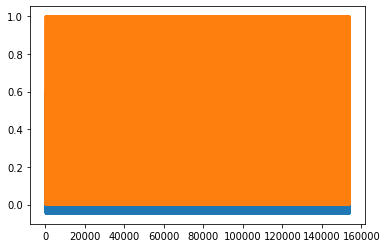

In [44]:
plt.plot(lineReg.predict(X_test))
plt.plot(y_test)
plt.show()

A better alternative is to use ridge regression.

Score:  0.2435036990516716
Weights:  [ 0.12407255  0.00659163  0.05635462 -0.2107165   0.07358752 -0.04039503
  0.22890144 -0.1973376   0.44298108 -0.23183088  0.07198388 -0.19352858
  0.00357989]


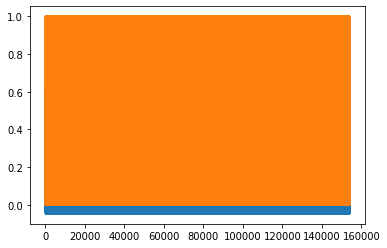

In [45]:
from sklearn import linear_model
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train)
print('Score: ', reg.score(X_test, y_test))
print('Weights: ', reg.coef_)

plt.plot(reg.predict(X_test))
plt.plot(y_test)
plt.show()